In [1]:
library(readr)
library(dplyr, warn=F)
library(ggplot2)
library(magrittr)

In [2]:
cols = list(
  cancer = '#F1A340',
  hema = '#F7F7F7',
  immune = '#998EC3',
  ms = '#423869'
)

In [3]:
get_pval_df = function(grouped_df) {
  grouped_df %>% dplyr::do(t.test(.$proximity ~ .$target_category) %$%
    dplyr::data_frame(statistic, p.value)) %>%
    dplyr::mutate(pval_str = sprintf("p%%~~%%%.2e", p.value)) %>%
    dplyr::mutate(pval_str = sub('e', '%*%10^', pval_str)) %>%
    dplyr::mutate(x = Inf, y = Inf)
}

gg_base = function(gg) {
    gg = gg + 
      ggplot2::theme_bw() + 
      ggplot2::theme(strip.background=ggplot2::element_rect(fill='#FEF2E2')) +
      ggplot2::theme(plot.margin = grid::unit(c(2, 2, 2, 2), 'points'))
    return(gg)
}

## Read proximity data

In [4]:
prox_df = readr::read_tsv('data/proximities.tsv')
cat_cols = list(
  category = readr::col_factor(levels = 
    c('Autoimmune', "multiple sclerosis", "Hodgkin's lymphoma", 'Hematologic Cancer', 'Solid Cancer'))
)
cat_df = readr::read_tsv('input/doid-categories.tsv', col_types = cat_cols)

prox_df = prox_df %>%
  dplyr::left_join(
    cat_df %>% dplyr::transmute(source_id = doid_code, source_category = category)
  ) %>%
  dplyr::left_join(
    cat_df %>% dplyr::transmute(target_id = doid_code, target_category = category)
  )

head(prox_df)

Joining by: "source_id"
Joining by: "target_id"


,source_id,source_name,target_id,target_name,proximity,source_category,target_category
1,DOID:10652,Alzheimer's disease,DOID:14221,metabolic syndrome X,0.208082,NA,NA
2,DOID:10652,Alzheimer's disease,DOID:1936,atherosclerosis,0.167257,NA,NA
3,DOID:10652,Alzheimer's disease,DOID:1107,esophageal carcinoma,0.107093,NA,Solid Cancer
4,DOID:10652,Alzheimer's disease,DOID:10286,prostate carcinoma,0.065227,NA,Solid Cancer
5,DOID:10652,Alzheimer's disease,DOID:10871,age related macular degeneration,0.055209,NA,NA
6,DOID:10652,Alzheimer's disease,DOID:1749,squamous cell carcinoma,0.04509,NA,Solid Cancer


In [5]:
prox_df %>% filter(source_category=='Hematologic Cancer') %>% distinct(source_name)

,source_id,source_name,target_id,target_name,proximity,source_category,target_category
1,DOID:8567,Hodgkin's lymphoma,DOID:9008,psoriatic arthritis,0.198044,Hematologic Cancer,Autoimmune
2,DOID:1040,chronic lymphocytic leukemia,DOID:14268,sclerosing cholangitis,0.091648,Hematologic Cancer,Autoimmune
3,DOID:9538,multiple myeloma,DOID:3620,central nervous system cancer,0.21223,Hematologic Cancer,Solid Cancer


## pairwise-proximities.pdf

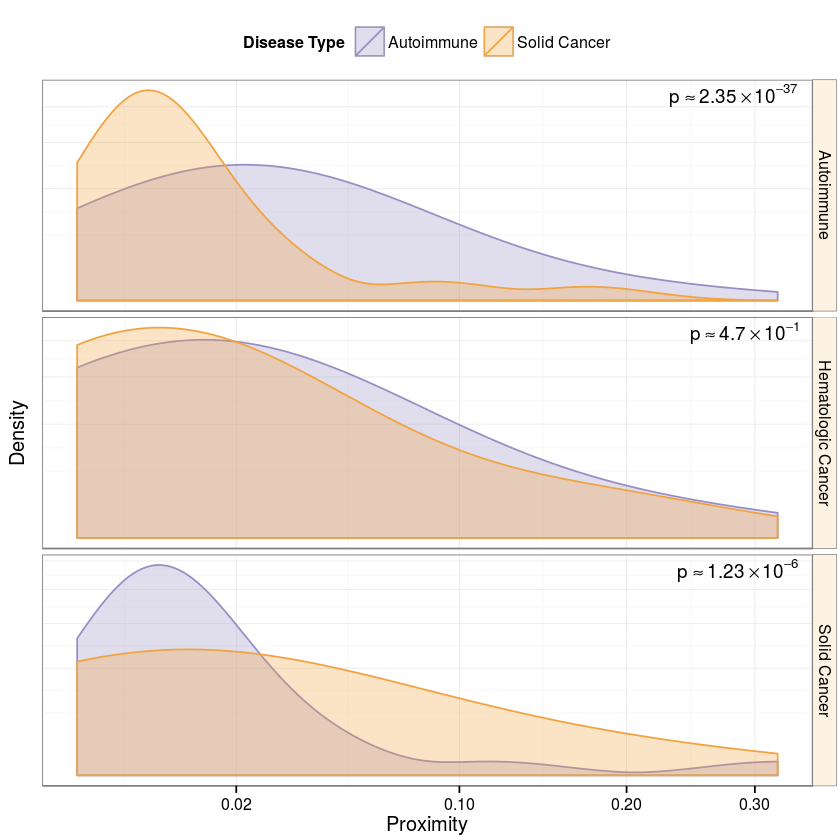

In [12]:
plot_df = prox_df %>%
  dplyr::filter(source_category %in% c('Solid Cancer', 'Hematologic Cancer', 'Autoimmune')) %>%
  dplyr::filter(target_category %in% c('Solid Cancer', 'Autoimmune'))

x_breaks = c(0, 0.02, 0.1, 0.2, 0.3)
x_lim = range(plot_df$proximity)

pval_df = plot_df %>%
  dplyr::group_by(source_category) %>%
  get_pval_df()

density_plot = plot_df %>%
  ggplot2::ggplot(aes(proximity, fill=target_category, color=target_category)) %>% gg_base +
  ggplot2::geom_density(alpha=0.3, adjust=5) +
  ggplot2::facet_grid(source_category ~ ., scales='free_y') +
  ggplot2::scale_fill_manual(values = c(cols$immune, cols$cancer)) +
  ggplot2::scale_color_manual(values = c(cols$immune, cols$cancer)) +
  ggplot2::xlab('Proximity') + ggplot2::ylab('Density') +
  ggplot2::guides(fill=guide_legend('Disease Type'), color=guide_legend('Disease Type')) +
  ggplot2::geom_text(data=pval_df, aes(x=x, y=y, label=pval_str, fill=NULL, color=NULL), 
    parse=TRUE, hjust=1.12, vjust=1.2, size=4, show_guide=FALSE) +
  ggplot2::theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), legend.position='top') +
  ggplot2::scale_x_sqrt(breaks = x_breaks, limits=x_lim) +
  ggplot2::scale_y_sqrt()

'figure/pairwise-proximities.pdf' %>% ggplot2::ggsave(density_plot, width=5, height=5.15)
'figure/pairwise-proximities.png' %>% ggplot2::ggsave(density_plot, width=5, height=5.15, dpi=300)
density_plot

## dotplot MS and HL

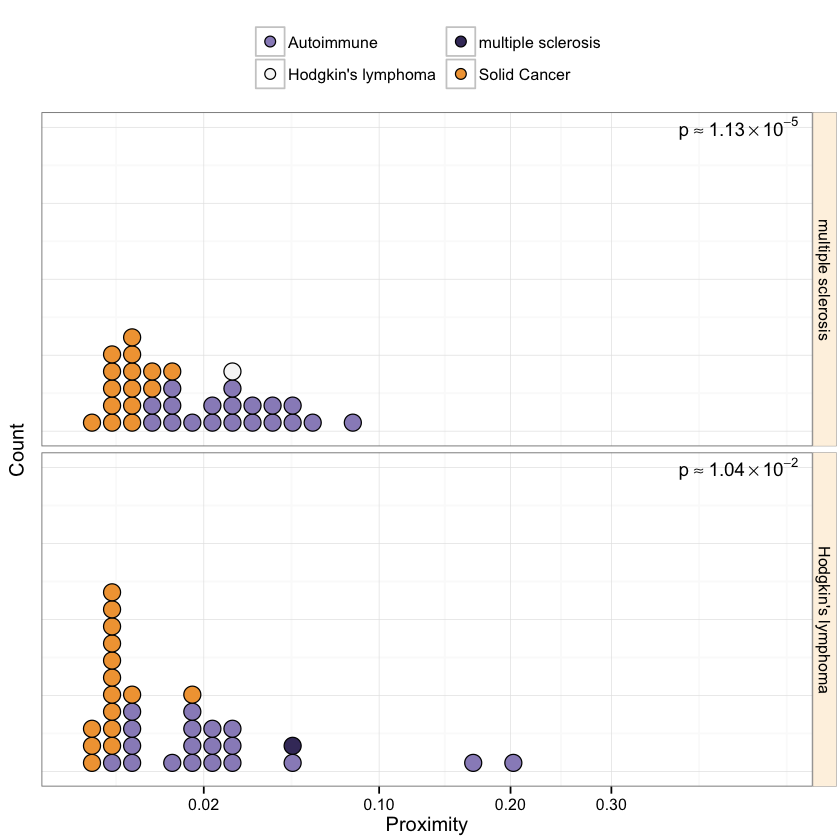

In [7]:
plot_df = prox_df %>%
  dplyr::filter(source_name %in% c('multiple sclerosis', "Hodgkin's lymphoma"))
plot_df[plot_df$target_name == "Hodgkin's lymphoma", 'target_category'] <- "Hodgkin's lymphoma"
plot_df %<>% dplyr::filter(target_category %in% c('Solid Cancer', "Hodgkin's lymphoma", 'multiple sclerosis', 'Autoimmune'))

pval_df = plot_df %>%
  dplyr::filter(target_category %in% c('Solid Cancer', 'Autoimmune')) %>%
  dplyr::group_by(source_name) %>%
  get_pval_df()

# MS and HL dotplot
plot_df[plot_df$target_name == "multiple sclerosis", 'target_category'] <- "multiple sclerosis"
plot_df$source_name <- factor(plot_df$source_name, levels=c('multiple sclerosis', "Hodgkin's lymphoma"))
pval_df$source_name <- factor(pval_df$source_name, levels=c('multiple sclerosis', "Hodgkin's lymphoma"))

mshl_plot <- plot_df %>%
  ggplot2::ggplot(aes(proximity, fill=target_category)) %>% gg_base +
  ggplot2::geom_dotplot(stackgroups = TRUE, method='histodot', binwidth=0.02, dotsize=.85) + 
  ggplot2::facet_grid(source_name ~ ., scales='free_y') +
  ggplot2::theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), legend.position='top') +
  ggplot2::scale_fill_manual(values=c(cols$immune, cols$ms, cols$hema, cols$cancer)) +
  ggplot2::xlab('Proximity') + ggplot2::ylab('Count') +
  ggplot2::guides(fill=guide_legend('', nrow=2, byrow=TRUE)) +
  ggplot2::geom_text(data=pval_df, aes(x=x, y=y, label=pval_str, fill=NULL, color=NULL), 
    parse=TRUE, hjust=1.12, vjust=1.2, size=4, show_guide=FALSE) +
  ggplot2::scale_x_sqrt(breaks = x_breaks, limits=x_lim)

'figure/ms-hl-dotplot.pdf' %>% ggplot2::ggsave(mshl_plot, width=5, height=4.1)
'figure/ms-hl-dotplot.png' %>% ggplot2::ggsave(mshl_plot, width=5, height=4.1, dpi=300)
mshl_plot

## dotplot diseasome

In [8]:
plot_df = prox_df %>%
  dplyr::filter(source_category %in% c('Solid Cancer', 'Hematologic Cancer', 'Autoimmune')) %>%
  dplyr::filter(target_category %in% c('Solid Cancer', 'Hematologic Cancer', 'Autoimmune'))

plot_df[plot_df$target_name == "Hodgkin's lymphoma", 'target_category'] <- "Hodgkin's lymphoma"
plot_df %<>%
  dplyr::filter(target_category %in% c('Solid Cancer', "Hodgkin's lymphoma", 'Autoimmune', "multiple sclerosis"))

pval_df = plot_df %>%
  dplyr::filter(target_category %in% c('Solid Cancer', 'Autoimmune')) %>%
  dplyr::group_by(source_name) %>%
  get_pval_df()

plot_df[plot_df$target_name == "multiple sclerosis", 'target_category'] <- "multiple sclerosis"

prox_plot <- plot_df %>%
  ggplot2::ggplot(aes(proximity, fill=target_category)) %>% gg_base +
  ggplot2::geom_dotplot(stackgroups = TRUE, method='histodot', binwidth=0.02) + 
  ggplot2::facet_wrap(~ source_name, scales='free_y', ncol=3) +
  ggplot2::theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
  ggplot2::scale_fill_manual(values=c(cols$immune, cols$ms, cols$hema, cols$cancer)) +
  ggplot2::xlab('Proximity') + ggplot2::ylab('Count') +
  ggplot2::guides(fill=guide_legend('Disease:')) +
  ggplot2::geom_text(data=pval_df, aes(x=x, y=y, label=pval_str, fill=NULL, color=NULL), 
    parse=TRUE, hjust=1.12, vjust=1.2, size=4, show_guide=FALSE) +
  ggplot2::theme(legend.position='top') +
  ggplot2::scale_x_sqrt(breaks = c(0, 0.02, 0.1, 0.2, 0.3))

'figure/disease-proximities.pdf' %>% ggplot2::ggsave(prox_plot, width=7.5, height=18, limitsize=FALSE)
'figure/disease-proximities.png' %>% ggplot2::ggsave(prox_plot, width=7.5, height=18, limitsize=FALSE, dpi=300)